In [94]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from glob import glob
import pickle
%matplotlib inline

In [6]:
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
fpath = glob("./data/female/*.jpg")
mpath = glob("./data/male/*.jpg")

In [14]:
haar = cv2.CascadeClassifier("./model/haarcascade_frontalface_default.xml")


def extract_images(path,haar,gender,num):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = haar.detectMultiScale(gray,1.5,3)
    for x,y,w,h in faces:
        crop_img = img[y:y+h,x:x+h]
        if gender == "female":
            cv2.imwrite(f"./data/crop_female/{gender}_{num}.png",crop_img)
        else:
            cv2.imwrite(f"./data/crop_male/{gender}_{num}.png",crop_img)

In [15]:
#Crop whole images
for i,path in enumerate(fpath):
    extract_images(path,haar,"female",i)
    
for i,path in enumerate(mpath):
    extract_images(path,haar,"male",i)

In [21]:
#Scaling the cropped images. All of them have different h,w ratio. Check for the least and take it as a standard
cfpath= glob("./data/crop_female/*.png")
cmpath= glob("./data/crop_male/*.png")
path = cmpath + cfpath

In [25]:
#Get size of image
def size(path):
    img = Image.open(path)
    return img.size[0] #taking either h or w is enough as its square matrix

In [28]:
#Convert to df
data = pd.DataFrame(path,columns = ["path"])
data["size"] = data["path"].apply(lambda x: size(x))
data.head()

,path,size
0,./data/crop_male\male_0.png,182
1,./data/crop_male\male_1.png,122
2,./data/crop_male\male_1003.png,81
3,./data/crop_male\male_1005.png,122
4,./data/crop_male\male_1007.png,273


In [45]:
path.index("./data/crop_female\\female_0.png")
path.index("./data/crop_female\\female_6999.png")

3034

7029

In [48]:
path[3134]

'./data/crop_female\\female_1148.png'

In [29]:
#EDA
data.shape
data.info()
data.describe() #check max and min wdth

(7237, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7237 entries, 0 to 7236
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    7237 non-null   object
 1   size    7237 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 113.2+ KB


,size
count,7237.000000
mean,153.781401
std,74.497387
min,24.000000
25%,81.000000
50%,122.000000
75%,182.000000
max,410.000000


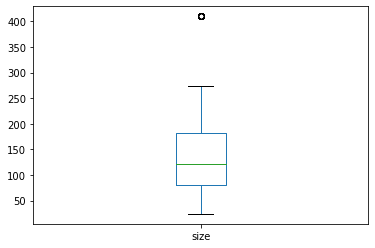

In [51]:
data["size"].plot(kind="box")

(array([  48.,    0.,  773.,    0., 1247.,    0.,    0., 1766.,    0.,
           0.,    0.,    0., 1978.,    0.,    0.,    0.,    0.,    0.,
           0., 1395.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,   30.]),
 array([ 24.        ,  36.86666667,  49.73333333,  62.6       ,
         75.46666667,  88.33333333, 101.2       , 114.06666667,
        126.93333333, 139.8       , 152.66666667, 165.53333333,
        178.4       , 191.26666667, 204.13333333, 217.        ,
        229.86666667, 242.73333333, 255.6       , 268.46666667,
        281.33333333, 294.2       , 307.06666667, 319.93333333,
        332.8       , 345.66666667, 358.53333333, 371.4       ,
        384.26666667, 397.13333333, 410.        ]),
 <a list of 30 Patch objects>)

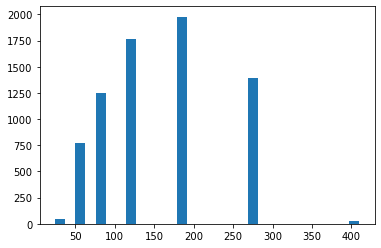

In [52]:
plt.hist(data["size"],bins = 30) #lets consider above 60,as the major part falls there. Resize to 100*100


In [54]:
df = data[data["size"] > 60]
df.head()
df.shape

,path,size
0,./data/crop_male\male_0.png,182
1,./data/crop_male\male_1.png,122
2,./data/crop_male\male_1003.png,81
3,./data/crop_male\male_1005.png,122
4,./data/crop_male\male_1007.png,273


(6416, 2)

In [68]:
# x = df.iloc[1,0]
# x.split("_")[1].split("\\")[-1]

'male'

In [69]:
df["gender"] = df["path"].apply(lambda x:x.split("_")[1].split("\\")[-1])

In [72]:
df["gender"].value_counts()
df["gender"].value_counts(normalize = True)

female    3757
male      2659
Name: gender, dtype: int64

female    0.585567
male      0.414433
Name: gender, dtype: float64

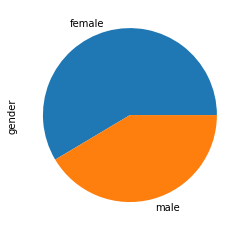

In [71]:
df["gender"].value_counts().plot(kind="pie") #Major female

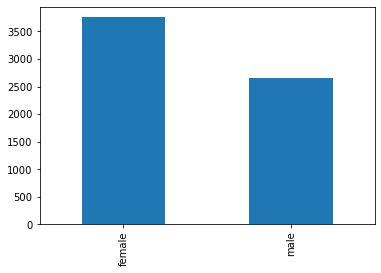

In [73]:
df["gender"].value_counts().plot(kind="bar")

In [74]:
#ratio is 60:40 which is acceptable, hence consider as balanced dataset.
df["size"].min()

81

In [84]:
#Image resize

def resize(row):
    try:
        img = cv2.imread(row)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        size = gray.shape[0]
        if size >= 100: 
            res = cv2.resize(gray,(100,100),cv2.INTER_AREA) #Shrink
        else:
            res = cv2.resize(gray,(100,100),cv2.INTER_CUBIC) #Expand
        flat_img = res.flatten()
        return flat_img
    except:
        return None

In [85]:
df["resize"] = df["path"].apply(resize)

In [86]:
df.head()

,path,size,gender,resize
0,./data/crop_male\male_0.png,182,male,"[106, 100, 81, 69, 71, 48, 51, 55, 41, 17, 30,..."
1,./data/crop_male\male_1.png,122,male,"[49, 50, 49, 50, 50, 48, 47, 47, 46, 48, 50, 4..."
2,./data/crop_male\male_1003.png,81,male,"[165, 184, 209, 224, 220, 211, 193, 170, 153, ..."
3,./data/crop_male\male_1005.png,122,male,"[141, 143, 148, 156, 161, 173, 157, 138, 146, ..."
4,./data/crop_male\male_1007.png,273,male,"[180, 115, 41, 103, 23, 25, 36, 35, 25, 31, 38..."


In [89]:
df.shape

(6416, 4)

In [88]:
# df1 = df["resize"].apply(pd.Series)
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,106,100,81,69,71,48,51,55,41,17,...,17,18,26,28,31,30,31,29,31,31
1,49,50,49,50,50,48,47,47,46,48,...,138,139,140,142,145,147,151,148,138,130
2,165,184,209,224,220,211,193,170,153,148,...,14,14,14,13,13,14,14,14,14,15
3,141,143,148,156,161,173,157,138,146,121,...,205,203,173,86,72,60,46,59,88,148
4,180,115,41,103,23,25,36,35,25,31,...,112,110,104,112,86,83,116,126,111,113


In [91]:
#Data to be trained
df2 = pd.concat((df["gender"],df1),axis=1)
df2.head()
df2.shape

,gender,0,1,2,3,4,5,6,7,8,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,male,106,100,81,69,71,48,51,55,41,...,17,18,26,28,31,30,31,29,31,31
1,male,49,50,49,50,50,48,47,47,46,...,138,139,140,142,145,147,151,148,138,130
2,male,165,184,209,224,220,211,193,170,153,...,14,14,14,13,13,14,14,14,14,15
3,male,141,143,148,156,161,173,157,138,146,...,205,203,173,86,72,60,46,59,88,148
4,male,180,115,41,103,23,25,36,35,25,...,112,110,104,112,86,83,116,126,111,113


(6416, 10001)

Text(0.5, 1.0, 'Label: male')

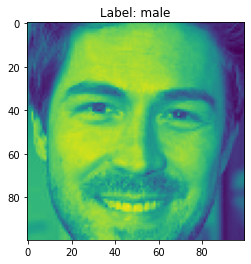

In [93]:
#check one image with the flattened array values
plt.imshow(df2.iloc[0,1:].values.reshape(100,100).astype("int"))
plt.title("Label: "+df2.iloc[0,0])

In [103]:
#Save the df in pickle format
pickle.dump(df2,open('./data/df_100_100.pkl','wb'))

In [106]:
#Data Cleaning and Preparation 
df2.info()

#
df2.isnull().sum() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6416 entries, 0 to 7236
Columns: 10001 entries, gender to 9999
dtypes: object(1), uint8(10000)
memory usage: 61.6+ MB


gender    0
0         0
1         0
2         0
3         0
         ..
9995      0
9996      0
9997      0
9998      0
9999      0
Length: 10001, dtype: int64

In [107]:
# Data Normalization
#many outliers = std scaling
#no or less outliers = min max scaling

X = df2.iloc[:,1:].values
y = df2.iloc[:,0].values

In [109]:
X.shape
y.shape

(6416, 10000)

(6416,)

##### MIN MAX SCALER
##### Xnorm = $\frac{x-minVal} {maxVal - minVal}$

In [111]:
X.min() 
X.max()

0

255

In [112]:
Xnorm = X/X.max()
Xnorm.shape

(6416, 10000)

In [114]:
ynorm = np.where(y == "female",1,0)
ynorm

array([0, 0, 0, ..., 1, 1, 1])

In [115]:
#Save X and y norms
np.savez("./data/data_100_norm",Xnorm,ynorm)

In [ ]:
#EIGEN FACE RECOGNITION
